## Import necessary packages

In [1]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

## Load pelvic region images
Images files are from the NIH Visible Human Project CT Dataset

In [ ]:
data_path = "/Users/jihye/Projects/research/05_practice_images/000-000-002/scans/1-Resampled_to_1mm_voxels/resources/DICOM/files/"
output_path = working_path = "/Users/jihye/Projects/research/05_practice_images"
g = glob(data_path + '/*.dcm')

## Functions for loading files and converting to Housenfield Units

In [3]:
# loop over image files and store everything into a list
def load_scan(path):    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] # os.listdir() gets list of all files and directories
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

# convert pixels to Housenfield Units (scale for describing radiodensity for medical images)
def get_pixels_hu(scans): # input is output from load_scans
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept if 'RescaleIntercept' in scans[0] else -1024
    slope = scans[0].RescaleSlope if 'RescaleSlope' in scans[0] else 1
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

np.save(output_path + "/" + "fullimages_%d.npy" % (id), imgs)

## Histogram based on HU from medical images

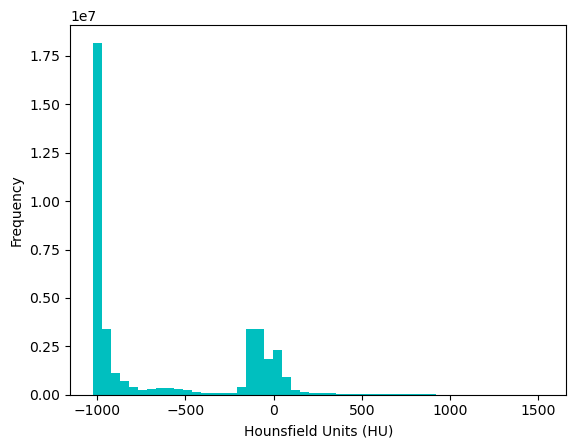

In [4]:
# displaying histogram based on HU
# histagram shows lots of air, some lung, lots of soft tissue (mostly muscle and liver, some fat), some bone
file_used=output_path+"/fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

## Selection of 2D images displayed in a stack

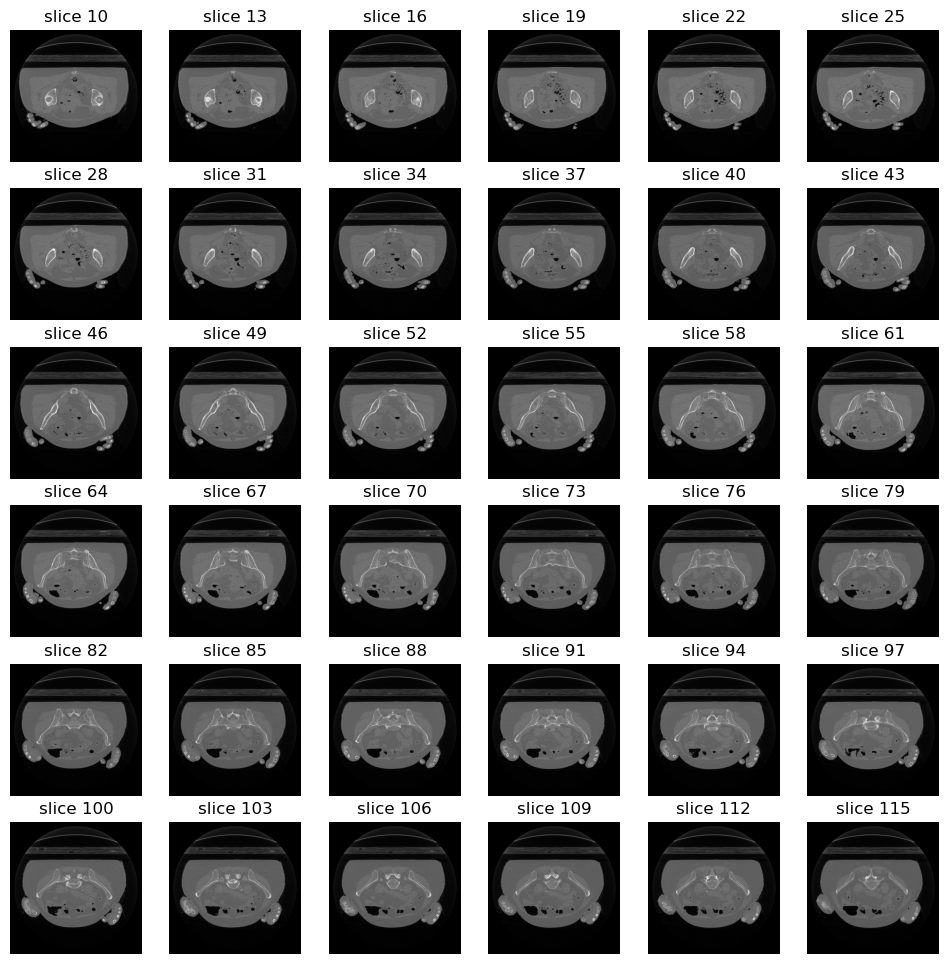

In [5]:
# displaying image stack
id = 0
imgs_to_process = np.fliplr(np.load(output_path + '/' + 'fullimages_{}.npy'.format(id)))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

## Resample the image data to be isovoxel

In [9]:
# resampling
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

id = 0
imgs_to_process = np.fliplr(np.load(output_path+'/' + 'fullimages_{}.npy'.format(id)))

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Slice Thickness: 1.000000
Pixel Spacing (row, col): (1.000000, 1.000000) 
Shape before resampling	 (150, 512, 512)
Shape after resampling	 (150, 512, 512)


## Make a mesh and create a 3D visualization of the images

In [7]:
# 3D plotting
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    # marching cubes algorithm is used to generate 3D mesh from dataset
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    
    ax.invert_yaxis()
    
    plt.show()


Transposing surface
Calculating surface
Drawing


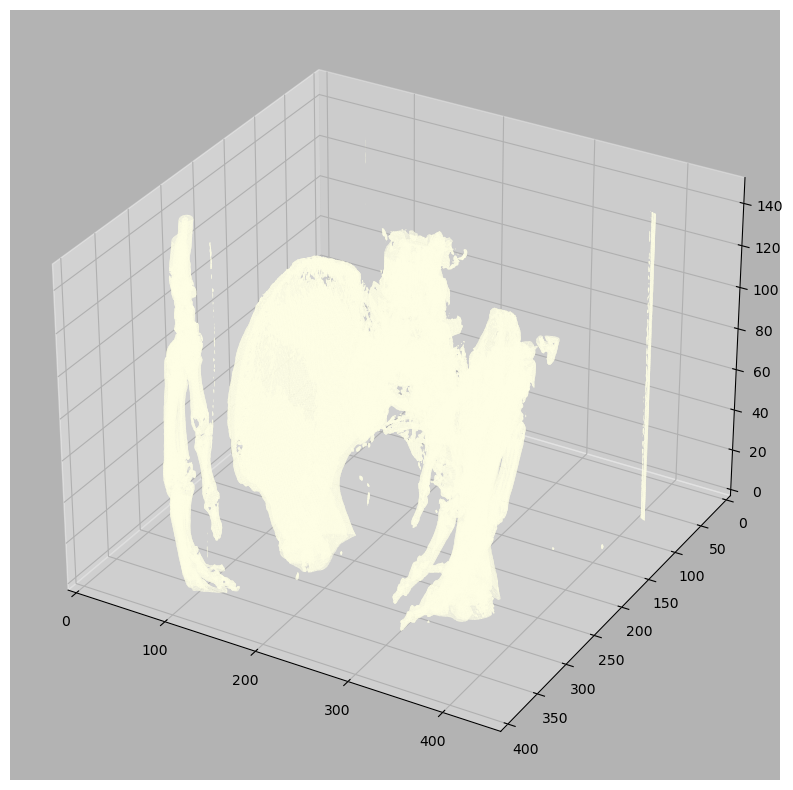

In [10]:
v, f = make_mesh(imgs_after_resamp, 300)
plt_3d(v,f)